In [1]:
import pandas as pd
import numpy as np


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

In [4]:

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))


In [5]:

df=pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [6]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

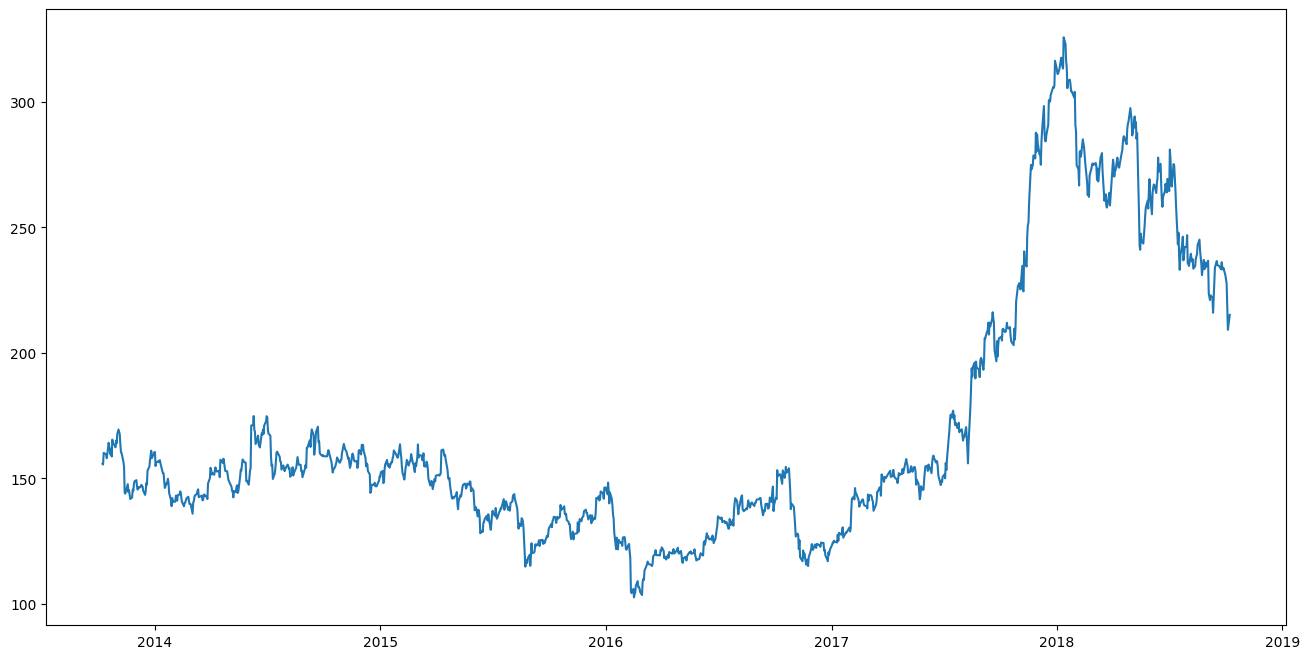

In [7]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [8]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [9]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [10]:



for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2846421087.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Date"][i]=data['Date'][i]
C:\Users\HP\AppData\Local\Temp\ipykernel_16136\2846421087.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Close"][i]=data["Close"][i]


In [11]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [12]:
final_dataset=new_dataset.values

In [13]:

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]


In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [15]:
x_train_data,y_train_data=[],[]

In [16]:
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [17]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

In [18]:


x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [19]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [20]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)



927/927 - 40s - loss: 0.0011 - 40s/epoch - 43ms/step


In [21]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [22]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [23]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

8/8 [==============================] - 3s 27ms/step


In [24]:
lstm_model.save("saved_lstm_model.h5")


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\HP\AppData\Local\Temp\ipykernel_16136\4128311284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


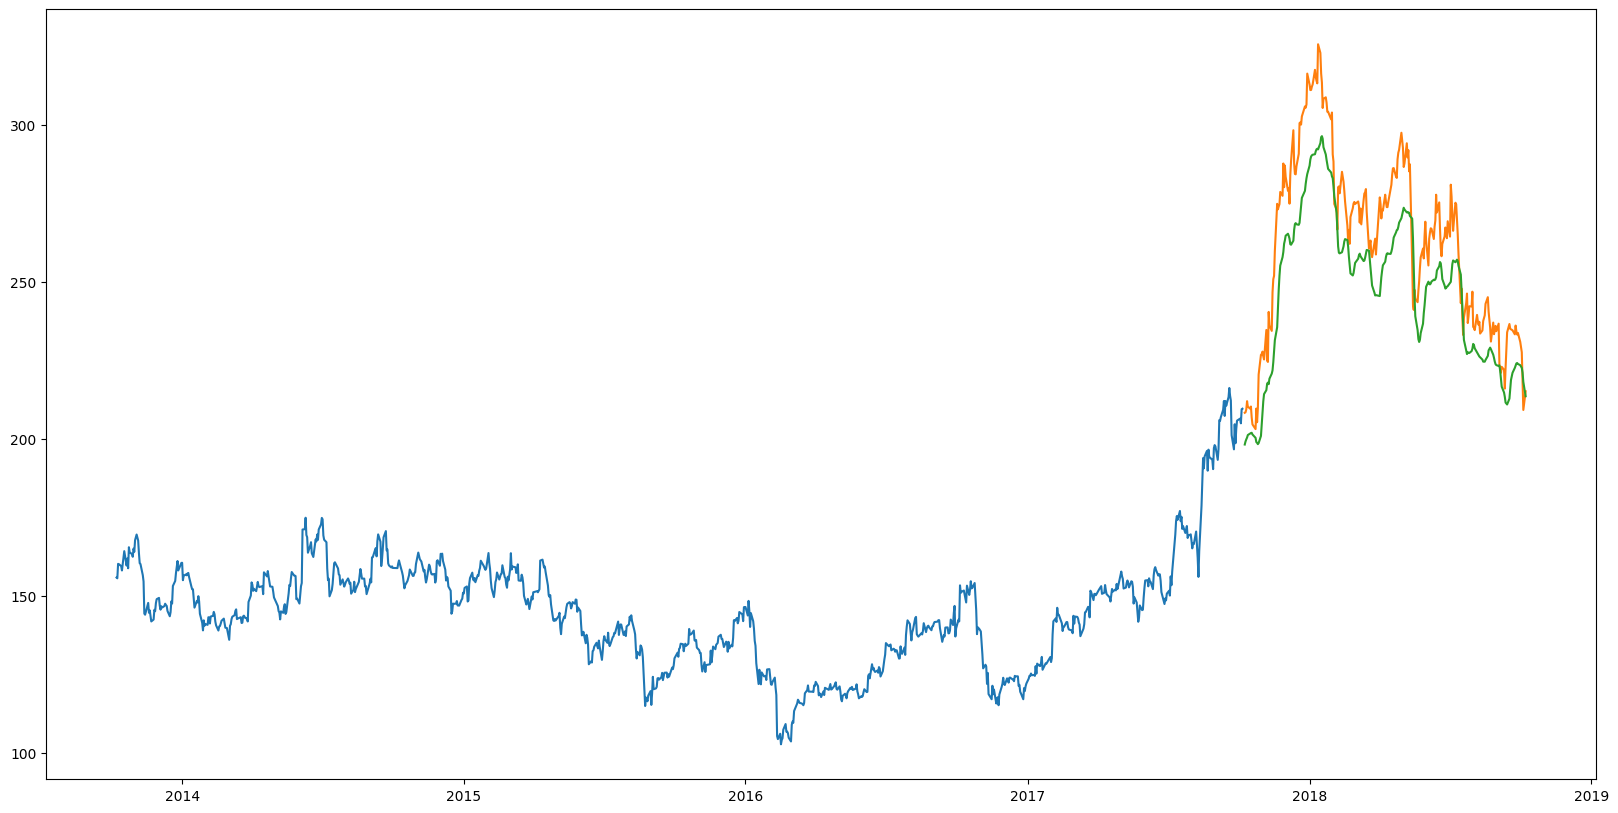

In [25]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])